In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import time
import datetime
from sklearn.model_selection import train_test_split

In [12]:
train = pd.read_csv('data/features.csv', index_col='match_id')
test = pd.read_csv('data/features_test.csv', index_col='match_id')

In [13]:
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [14]:
print(train.shape)
print(test.shape)

(97230, 108)
(17177, 102)


In [15]:
train.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1, inplace=True)

In [16]:
train['radiant_win'].value_counts()

1    50414
0    46816
Name: radiant_win, dtype: int64

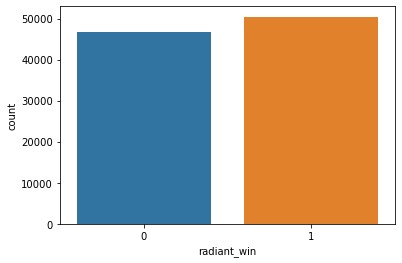

In [17]:
sns.countplot(x='radiant_win', data=train)

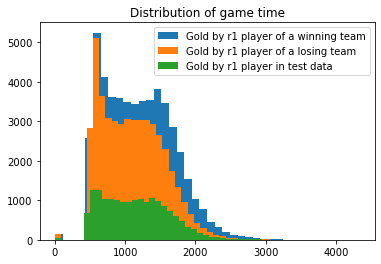

In [18]:
plt.hist(train.loc[train['radiant_win'] == True, 'r1_gold'], bins=40, label='Gold by r1 player of a winning team');
plt.hist(train.loc[train['radiant_win'] == False, 'r1_gold'], bins=40, label='Gold by r1 player of a losing team');
plt.hist(test['r1_gold'], bins=40, label='Gold by r1 player in test data');
plt.title('Distribution of game time');
plt.legend();

In [19]:
for col in train.columns:
    if train[col].isnull().any():
        print(col, train[col].isnull().sum())

first_blood_time 19553
first_blood_team 19553
first_blood_player1 19553
first_blood_player2 43987
radiant_bottle_time 15691
radiant_courier_time 692
radiant_flying_courier_time 27479
radiant_first_ward_time 1836
dire_bottle_time 16143
dire_courier_time 676
dire_flying_courier_time 26098
dire_first_ward_time 1826


In [20]:
for col in train.columns:
    if train[col].isnull().any():
        train[col] = train[col].fillna(0)
        print(col, train[col].isnull().sum())

first_blood_time 0
first_blood_team 0
first_blood_player1 0
first_blood_player2 0
radiant_bottle_time 0
radiant_courier_time 0
radiant_flying_courier_time 0
radiant_first_ward_time 0
dire_bottle_time 0
dire_courier_time 0
dire_flying_courier_time 0
dire_first_ward_time 0


In [21]:
y = train['radiant_win']
x = train.drop(['radiant_win'], axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 1)

In [43]:
start_time = datetime.datetime.now()
cv = KFold(shuffle=True, n_splits=5, random_state=1)
clf = GradientBoostingClassifier()
params = {'n_estimators':[10, 20, 30, 40]}
grid = GridSearchCV(clf, param_grid=params, cv=cv, verbose=1, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Time elapsed:', datetime.datetime.now() - start_time)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.2min finished


Time elapsed: 0:06:50.051352


In [44]:
res = (
    pd.DataFrame({
        "mean_test_score": grid.cv_results_["mean_test_score"],
        "mean_fit_time": grid.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid.cv_results_["params"]).add_prefix("param_"))
)
res

,mean_test_score,mean_fit_time,param_n_estimators
0,0.663334,7.646340,10
1,0.680236,15.866958,20
2,0.688462,22.196655,30
3,0.692732,28.772811,40


In [45]:
grid30 = GradientBoostingClassifier(n_estimators=30)
start_time = datetime.datetime.now()
score = cross_val_score(estimator=grid30, X=X_train, y=y_train, cv=cv, scoring='roc_auc')
print('Time elapsed:', datetime.datetime.now() - start_time)
print(score.mean())

Time elapsed: 0:01:49.504877
0.6884621661727879


In [46]:
start_time = datetime.datetime.now()
score2 = cross_val_score(estimator=grid30, X=x, y=y, cv=cv, scoring='roc_auc')
print('Time elapsed:', datetime.datetime.now() - start_time)
print(score2.mean())

Time elapsed: 0:02:46.756931
0.6896947542059906


# Logistic regression

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
kf = KFold(shuffle=True, n_splits=5, random_state=1)

In [55]:
len(X_scaled)

97230

In [57]:
start_time = datetime.datetime.now()

params = {'C': np.power(10.0, np.arange(-4, 2, 1))}
clf_lr = LogisticRegression(verbose=0, random_state=1)
clf_lr_gs = GridSearchCV(estimator=clf_lr, param_grid=params, cv=kf, verbose=0, scoring='roc_auc')
clf_lr_gs.fit(X_scaled, y)
print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:36.085050


In [60]:
y_score_lr = clf_lr_gs.decision_function(X_scaled)

print(clf_lr_gs.best_params_)
print(roc_auc_score(y, y_score_lr))

{'C': 0.01}
0.7179816486036966


In [58]:
res2 = (
    pd.DataFrame({
        "mean_test_score": clf_lr_gs.cv_results_["mean_test_score"],
        "mean_fit_time": clf_lr_gs.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(clf_lr_gs.cv_results_["params"]).add_prefix("param_"))
)
res2

,mean_test_score,mean_fit_time,param_C
0,0.711281,0.466406,0.0001
1,0.716210,0.852000,0.0010
2,0.716375,1.246603,0.0100
3,0.716351,1.288800,0.1000
4,0.716348,1.322001,1.0000
5,0.716347,1.499213,10.0000


In [62]:
categorical = ['lobby_type']
for t in ['r', 'd']:
    for i in range(1, 6):
        categorical.append(f'{t}{i}_hero')
categorical

['lobby_type',
 'r1_hero',
 'r2_hero',
 'r3_hero',
 'r4_hero',
 'r5_hero',
 'd1_hero',
 'd2_hero',
 'd3_hero',
 'd4_hero',
 'd5_hero']

In [64]:
X_cat = x.drop(categorical, axis=1)

In [65]:
X_cat_scaled = scaler.fit_transform(X_cat)

In [71]:
clf_lr_gs_cat = clf_lr_gs

In [73]:
start_time = datetime.datetime.now()

clf_lr_gs_cat.fit(X_cat_scaled, y)
print('Time elapsed:', datetime.datetime.now() - start_time)

y_cat = clf_lr_gs_cat.decision_function(X_cat_scaled)
print(clf_lr_gs_cat.best_params_)
print(roc_auc_score(y, y_cat))

y_cat = clf_lr_gs.decision_function(X_cat_scaled)
print(clf_lr_gs.best_params_)
print(roc_auc_score(y, y_cat))

Time elapsed: 0:00:35.482002
{'C': 0.01}
0.7178406315021261
{'C': 0.01}
0.7178406315021261


In [74]:
res3 = (
    pd.DataFrame({
        "mean_test_score": clf_lr_gs_cat.cv_results_["mean_test_score"],
        "mean_fit_time": clf_lr_gs_cat.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(clf_lr_gs_cat.cv_results_["params"]).add_prefix("param_"))
)
res3

,mean_test_score,mean_fit_time,param_C
0,0.711259,0.447608,0.0001
1,0.716233,0.893204,0.0010
2,0.716410,1.424000,0.0100
3,0.716384,1.348802,0.1000
4,0.716380,1.223402,1.0000
5,0.716380,1.226601,10.0000


In [75]:
s = set()
for i in categorical[1:]:
    for j in (x[i].unique()):
        s.add(j)

In [77]:
X_pick = np.zeros((x.shape[0], 112))

for i, match_id in enumerate(x.index):
    for p in range(5):
        X_pick[i, x.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, x.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [78]:
X_in_bag = np.hstack((X_cat_scaled, X_pick))

In [82]:
start_time = datetime.datetime.now()
clf_lr_gs_cat.fit(X_in_bag, y)
print('Time elapsed:', datetime.datetime.now() - start_time)

c:\users\влад каминский\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\влад каминский\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver optio

Time elapsed: 0:01:33.953006


c:\users\влад каминский\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


NameError: name 'gs4' is not defined

In [83]:
res4 = (
    pd.DataFrame({
        "mean_test_score": clf_lr_gs_cat.cv_results_["mean_test_score"],
        "mean_fit_time": clf_lr_gs_cat.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(clf_lr_gs_cat.cv_results_["params"]).add_prefix("param_"))
)
res4

,mean_test_score,mean_fit_time,param_C
0,0.724978,0.891996,0.0001
1,0.746211,1.800803,0.0010
2,0.751652,3.458798,0.0100
3,0.751874,3.973004,0.1000
4,0.751857,3.706402,1.0000
5,0.751854,3.681602,10.0000


In [84]:
y_bag = clf_lr_gs_cat.decision_function(X_in_bag)

print(clf_logreg_grid.best_params_)
print(roc_auc_score(y, y_bag))

{'C': 0.1}
0.7544462650687712


In [86]:
test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [88]:
X_test = test.iloc[:, 1:]

In [91]:
X_test = test.fillna(0)

In [94]:
X_pick_test = np.zeros((X_test.shape[0], 112))

for i, match_id in enumerate(X_test.index):
    for p in range(5):
        X_pick_test[i, X_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, X_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [96]:
X_test.drop(categorical, inplace=True, axis=1)

In [97]:
X_scaled_test = scaler.fit_transform(X_test)

In [98]:
X_in_bag_test = np.hstack((X_scaled_test, X_pick_test))

In [100]:
y_pred = clf_lr_gs_cat.best_estimator_.predict_proba(X_in_bag_test)

In [101]:
y_pred = pd.DataFrame(y_pred)
y_pred.mean()

0    0.481795
1    0.518205
dtype: float64

In [102]:
result = y_pred
result.columns = ['match_id', 'radiant_win']
result.index = X_test.index
result = result.drop(labels='match_id', axis=1)

In [103]:
result.head()

,radiant_win
match_id,
6,0.824602
7,0.757280
10,0.187514
13,0.862807
16,0.239929


In [104]:
result.to_csv('submission_1.csv',
             index = True)